# notebook with tasks for Capital One Data Science Challenge

## Executive Summary  

#### Question 1: Load

- a) Please describe the structure of the data. Number of records and fields in each record?
    - the number of records in total is 786,363 that span across 29 columns
    - there are numeric, text and date columns throughout the dataset but the date columns have not been converted to dates
    - there is a transactionDateTime column that is still stored as text after initial import that we'll need to convert to time, along with currentExpDate, accountOpenDate and dateOfLastAddressChange
    - null values aren't counted as nulls but are rather empty strings so i converted these nulls to have value "blank"
    
- b) Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate.
    - the numeric values have reasonable upper and lower limits: availableMoney has a negative value which is reasonable because the balance is greater than the creditLimit by the amount of availableMoney
    - the non-date string values dont have many unique values other than merchantName, 2,490, and merchantCategoryCode, 19, which aren't problematic but would need to be consolidated if we want to use them in a logistic regression model to prevent separability
    - tables available inline later

#### Question 2: Plot
- b) Report any structure you find and any hypotheses you have about that structure. 
    - the histogram of the transaction amount is largely right-skewed with a long right tail, largely following a log distribution
    - most of the density is for transaction amounts less than 500, which leads me to hypothesize that most of these transactions are for everyday consumer products, entertainment, travel and billpay transactions as opposed to larger transactions like rent and loan payments
    - another thing to note is that, because we'll be using this data to build a fraud model and most transactions seem like everyday purchases in that they're under \\$500, maybe the transactions over a certain dollar value, e.g. \\$1000, are more likely to be fraudulent
    
#### Question 3: Data Wrangling

- a) Can you programmatically identify reversed and multi-swipe transactions?
    - sort the transactions by accountNumber, customerId, cardLast4Digits and transactionDt
    - create copies of these variables and transactionAmount, transactionType and merchantName that are shifted so that the copied columns are shifted 1 row forward
    - identify reversed and multi_swipe transactions if the accountNumber, customerId, cardLast4Digits, transactionAmount and merchantName columns match for current and shift columns
        - within 24 hours
        - reversed if current row is reversal and shifted (previous) row is purchase
        - multi-swipe if amount is the same and transactionType is purchase for current and shifted rows
        
- b) What total number of transactions and total dollar amount do you estimate for the reversed transactions? For the multi-swipe transactions? (please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts)
    - \\$824K in reversed transactions and \\$1.08M for multi swipe transactions
    
- c) Did you find anything interesting about either kind of transaction?
    - I did not find any relationship between type of transaction and elevated percentages of reversed, multi-swipe or both kinds of duplicate transactions.
    - However, I did find that 6 merchant categories had no duplicate transactions at all - gym, fuel, cable/phone, online_subscriptions, food_delivery and mobileapps. I would hypothesize that this is something to do with card information saved so that it is not entered in by a human and instead automated, i.e. recurring subscription transactions like gym, cable/phone, online_subscriptions are likely saved and entered in an automated fashion. Mobileapps and food_delivery could be transacted by a user using his or her card saved to their phone, minimizing the likelihood of a duplicate. Why fuel has no duplicate transactions is the most interesting because I would suspect plenty of customers would still insert their cards manually at the pump unless these transactions are customers using the cards on their phones. 
    
#### Question 4: Model

- a) Provide an estimate of performance using an appropriate sample, and show your work.
    - after creating an 85% training and 15% test set that are mutually exclusive and collectively exhaustive, my best model was a gradient-boosted tree model with the following performance
    - True Positive Rate: 71%, False Positive Rate: 29%, Precision: 4%, Recall: 71%, AUC: 77%
    
- b) Please explain your methodology 
    - modeling algorithm/method used and why
        - fit a couple models with different parameterizations and objective functions because it is hard to understand how these variables are represented in high dimensions and in combination with each other outside of fitting the model
            - regularized logistic regression for linear parameterization of explanatory variables
            - gradient boosted tree for tree structure and boosting capability to improve model based on misclassified cases
            - naive bayes for bayesian parameterization assuming conditional independence 
    - what features/data you found useful
        - merchantName didnt appear to have any significant differences in percentage of fraudulent cases and would lead to over 2,400 columns to create the indicator variables used in the model so it was not included in the model
        - transactionAmount, log-transformed transactionAmount and hour of transaction appeared to have potential relationships with the response variable among continuous variables
        - blank values have a notably (maybe significant, maybe not) higher percentage of fraudulent transactions including within acqCountry, merchantCountryCode, posEntryMode, posConditionCode and transactionType, which isn't entirely surprising
        - transactions where the entered cvv and actual cvv don't match showed a higher percentage of fraudulent transactions
        - airlines, mobileapps, online_gifts and rideshare have notably higher percentages of fraudulent transactions as well
    - what questions you have
        - what do the different values of posEntryModel delineate?
        - what do the different values of posConditionCode encompass?
        - how is a transaction reported to be fraudulent? 
        - how was this sample of transactions chosen?
    - what you would do next with more time
        1. diaglogue with business stakeholders and analysts regarding trends in fraud cases that they have noticed to inform creating new derived variables and adding new variables
        2. determine what other data is available that could be used to add new explanatory variables in the model
        3. explore creating other derived explanatory variables, including interactions
        4. try other models with different objective functions and parameterizations including support vector machines, neural network, nearest neighbors, etc. to see if their performance is better than the xgb model
        5. examine the champion model's performance at different values of hyperparameters with a grid search. for the gradient boosted model, this would include learning rate, number of boosting rounds, weights for positive samples, sampling method, tree depth, lambda regularization parameter, boosting the model based on auc instead of mean average precision
        
Below are the code and answers to capital one's data science recruting challenge corresponding to the 4 questions of Load, Plot, Data Wrangling and Model

In [84]:
#import packages
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import datetime
import xgboost

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

#to display all columns in dataframe
from IPython.display import display
pd.options.display.max_columns = None

from patsy import dmatrices

%matplotlib inline

import data

In [2]:
trnz = pd.read_json(path_or_buf = "C://Users/campb/DS/transactions/transactions.txt", lines = True)

# Question 1: Load

- a) Please describe the structure of the data. Number of records and fields in each record?
- b) Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate.

answers a couple cells down after output is examined

In [3]:
trnz.shape

(786363, 29)

In [4]:
trnz.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.0,,,,True,,,False,False


In [5]:
trnz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

In [6]:
trnz.describe(include = 'all')

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
count,7.863630e+05,7.863630e+05,786363.000000,786363.000000,786363,786363.000000,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363.000000,786363.000000,786363.000000,786363,786363,786363.000000,786363,786363,786363,786363,786363,786363,786363,786363
unique,NaN,NaN,NaN,NaN,776637,NaN,2490,5,5,6,4,19,165,1820,2184,NaN,NaN,NaN,4,1,NaN,1,1,1,2,1,1,2,2
top,NaN,NaN,NaN,NaN,2016-12-25T14:04:15,NaN,Uber,US,US,05,01,online_retail,03/2029,2014-06-21,2016-03-15,NaN,NaN,NaN,PURCHASE,,NaN,,,,False,,,False,False
freq,NaN,NaN,NaN,NaN,4,NaN,25613,774709,778511,315035,628787,202156,5103,33623,3819,NaN,NaN,NaN,745193,786363,NaN,786363,786363,786363,433495,786363,786363,785320,773946
mean,5.372326e+08,5.372326e+08,10759.464459,6250.725369,NaN,136.985791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,544.467338,544.183857,4757.417799,NaN,NaN,4508.739089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2.554211e+08,2.554211e+08,11636.174890,8880.783989,NaN,147.725569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261.524220,261.551254,2996.583810,NaN,NaN,6457.442068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000881e+08,1.000881e+08,250.000000,-1005.630000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.301333e+08,3.301333e+08,5000.000000,1077.420000,NaN,33.650000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,310.000000,310.000000,2178.000000,NaN,NaN,689.910000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5.074561e+08,5.074561e+08,7500.000000,3184.860000,NaN,87.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,535.000000,535.000000,4733.000000,NaN,NaN,2451.760000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,7.676200e+08,7.676200e+08,15000.000000,7500.000000,NaN,191.480000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,785.000000,785.000000,7338.000000,NaN,NaN,5291.095000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


check availableMoney negative value

In [155]:
trnz.loc[ trnz.availableMoney == -1005.63, ['availableMoney', 'creditLimit', 'currentBalance']]

,availableMoney,creditLimit,currentBalance
746872,-1005.63,1000,2005.63


#### - a) Please describe the structure of the data. Number of records and fields in each record?

- the number of records in total is 786,363 that span across 29 columns
- there are numeric, text and date columns throughout the dataset but the date columns have not been converted to dates
- there is a transactionDateTime column that is still stored as text after initial import that we'll need to convert to time, along with currentExpDate, accountOpenDate and dateOfLastAddressChange
- the info() function says that there are no nulls for all of the columns but the head() output shows blank values for the 1st 5 rows of echoBuffer, merchantState, merchantZip, merchantCity, posOnPremises, recurringAuthInd and the describe function shows that these columns are entirely blank because there's only 1 unique value and its a blank string so we can just drop these columns
- lets check to see if there are any string or numeric values that are actually blank

#### - b) Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate. -> Seen in cell immediately above

- the numeric values have reasonable upper and lower limits: availableMoney has a negative value which is reasonable because the balance is greater than the creditLimit by the amount of availableMoney
- the non-date string values dont have many unique values other than merchantName, 2,490, and merchantCategoryCode, 19, which we'd need to consolidate if we want to do logistic regression to prevent separability

In [7]:
#drop columns with all blanks
trnz2 = trnz.drop(['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], axis = 1)

check if string variables are actually blanks

In [8]:
trnz2.apply(lambda x: (x == "").value_counts(), axis = 0)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
False,786363.0,786363.0,786363.0,786363.0,786363.0,786363.0,786363.0,781801,785639,782309,785954,786363.0,786363.0,786363.0,786363.0,786363.0,786363.0,786363.0,785665,786363.0,786363.0,786363.0,786363.0
True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4562,724,4054,409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,698,NaN,NaN,NaN,NaN


blanks in above string columns include
- 4,562 in acqCountry
- 724 in merchantCountryCode
- 4,054 in posEntryMode
- 409 in posConditionCode
- 698 in transactionType

In [9]:
trnz2.loc[ trnz2.acqCountry == ""].sample(30)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
494870,413425884,413425884,15000,8236.84,2016-03-30T10:29:17,86.91,Burger King #453332,,US,05,01,fastfood,04/2030,2015-07-18,2016-02-10,679,679,3549,PURCHASE,6763.16,True,False,False
456078,314028471,314028471,5000,1871.38,2016-12-10T15:52:31,55.86,Rodeway Inn #329268,,,09,01,hotels,08/2029,2014-05-10,2016-11-19,428,428,9541,REVERSAL,3128.62,True,False,False
519419,318313494,318313494,250,192.03,2016-12-06T11:45:21,64.63,ebay.com,,US,09,01,online_retail,03/2020,2008-12-29,2008-12-29,246,246,9344,PURCHASE,57.97,False,False,False
196600,918577577,918577577,15000,12702.40,2016-04-03T15:23:50,49.86,Fresh Flowers,,US,02,01,online_gifts,03/2033,2014-02-10,2014-02-10,172,172,0,PURCHASE,2297.60,False,False,False
141450,293511659,293511659,7500,5107.70,2016-07-02T11:49:43,67.06,Lyft,,US,05,08,rideshare,01/2020,2007-10-19,2016-05-16,568,568,2073,PURCHASE,2392.30,False,False,False
20390,617540437,617540437,250,153.45,2016-01-08T05:24:32,110.88,In-N-Out #80487,,,90,01,fastfood,10/2029,2014-06-06,2014-06-06,169,169,1241,PURCHASE,96.55,True,False,False
99883,740574175,740574175,15000,8815.05,2016-10-04T09:56:42,90.48,gap.com,,,05,01,online_retail,08/2025,2015-08-14,2016-09-26,531,531,6210,PURCHASE,6184.95,False,False,False
596475,967788744,967788744,5000,1860.55,2016-10-11T19:14:31,54.12,Mobil Gas #235527,,US,09,08,fuel,11/2026,2015-02-01,2015-02-01,509,509,1082,PURCHASE,3139.45,True,False,False
410154,325587097,325587097,20000,5187.85,2016-07-29T09:18:43,99.53,Washington Auto Body,,US,02,01,auto,04/2027,2013-10-08,2016-07-01,980,980,6709,PURCHASE,14812.15,True,False,False
432470,419709514,419709514,5000,410.47,2016-12-23T17:15:15,152.10,amazon.com,,US,05,08,online_retail,07/2024,2015-03-01,2016-12-17,917,917,2178,PURCHASE,4589.53,False,False,False


these are actually all blank for acqCountry so we'll replace these values of empty strings with "blank"

In [10]:
trnz2['acqCountry'] = np.where(trnz2.acqCountry == "", "blank", trnz2.acqCountry)
trnz2['merchantCountryCode'] = np.where(trnz2.merchantCountryCode == "", "blank", trnz2.merchantCountryCode)
trnz2['posEntryMode'] = np.where(trnz2.posEntryMode == "", "blank", trnz2.posEntryMode)
trnz2['posConditionCode'] = np.where(trnz2.posConditionCode == "", "blank", trnz2.posConditionCode)
trnz2['transactionType'] = np.where(trnz2.transactionType == "", "blank", trnz2.transactionType)

confirm whether blanks still exist

In [11]:
trnz2.apply(lambda x: (x == "").value_counts(), axis = 0)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
False,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363


no more blanks

nows lets try to see if there any numeric blanks

In [12]:
trnz2.apply(lambda x: (x == np.nan).value_counts(), axis = 0)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
False,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363


lets plot the numeric variables to see if there are any odd values that look like they could be placeholders for blanks

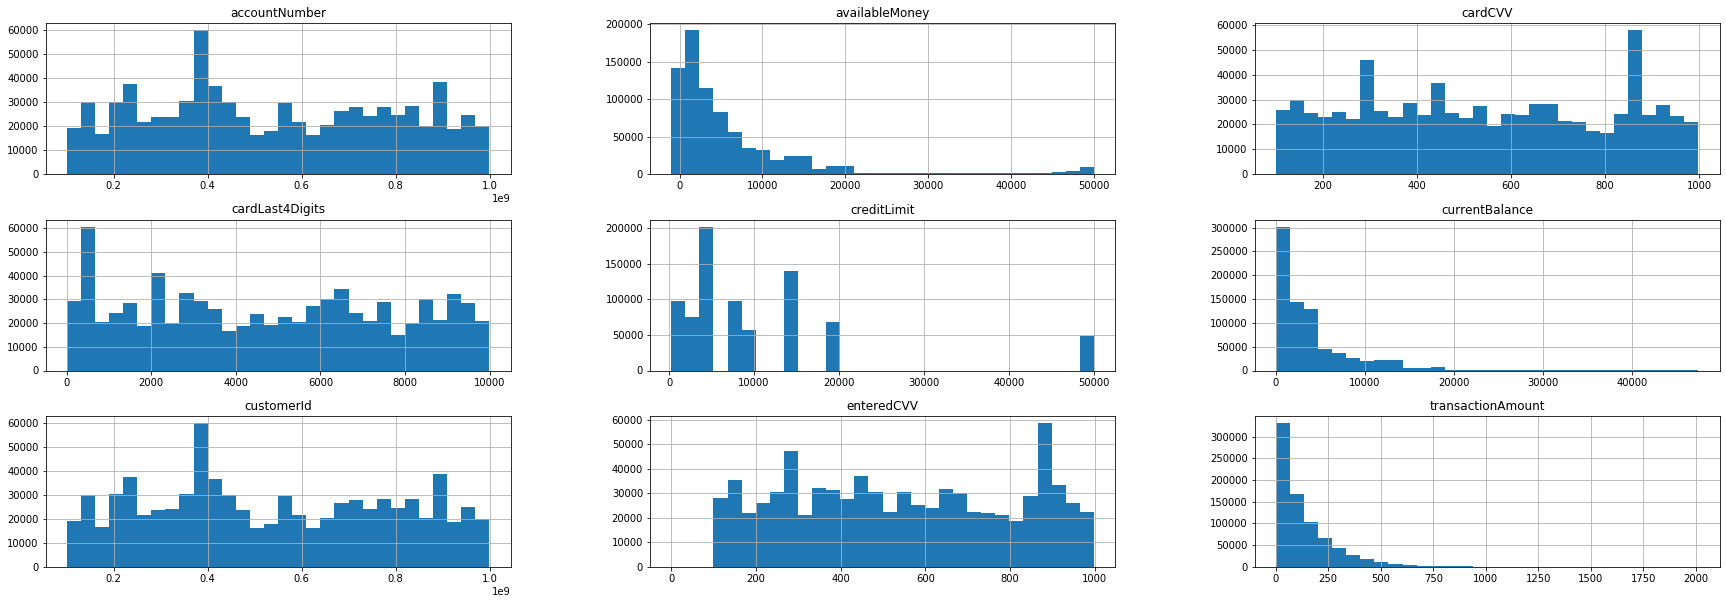

In [13]:
num_hist = plt.figure(figsize = (30, 10))
ax1 = num_hist.add_subplot(111)
trnz2.select_dtypes(include = ['int64', 'float64']).hist(ax = ax1, bins = 30);

- there are some numeric ranges that are markedly more popular like 4e8 in customerId and accountNumber but no values that are significantly farther away from the rest of the values like -9999 so we'll assume that none of the numeric values are blank
- creditLimit could potentially be treated as a categorical variable, which is something we could test and explore with more time

we'll convert the date columns to actual date values before moving forward
- transactionDateTime
- currentExpDate
- accountOpenDate
- dateOfLastAddressChange

In [14]:
trnz2[['transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange']].head()

,transactionDateTime,currentExpDate,accountOpenDate,dateOfLastAddressChange
0,2016-08-13T14:27:32,06/2023,2015-03-14,2015-03-14
1,2016-10-11T05:05:54,02/2024,2015-03-14,2015-03-14
2,2016-11-08T09:18:39,08/2025,2015-03-14,2015-03-14
3,2016-12-10T02:14:50,08/2025,2015-03-14,2015-03-14
4,2016-03-24T21:04:46,10/2029,2015-08-06,2015-08-06


In [15]:
trnz2['transactionDateTime_dt'] = pd.to_datetime(trnz2.transactionDateTime, format='%Y-%m-%dT%H:%M:%S')

In [16]:
trnz2['currentExpDate_dt'] = pd.to_datetime(trnz2.currentExpDate, format='%m/%Y')

In [17]:
trnz2['accountOpenDate_dt'] = pd.to_datetime(trnz2.accountOpenDate, format = '%Y-%m-%d')

In [18]:
trnz2['dateOfLastAddressChange_dt'] = pd.to_datetime(trnz2.dateOfLastAddressChange, format = '%Y-%m-%d')

confirm conversions are accurate

In [19]:
trnz2[['transactionDateTime', 'transactionDateTime_dt', 'currentExpDate', 'currentExpDate_dt', 'accountOpenDate', 'accountOpenDate_dt', 'dateOfLastAddressChange', 'dateOfLastAddressChange_dt']].head()

,transactionDateTime,transactionDateTime_dt,currentExpDate,currentExpDate_dt,accountOpenDate,accountOpenDate_dt,dateOfLastAddressChange,dateOfLastAddressChange_dt
0,2016-08-13T14:27:32,2016-08-13 14:27:32,06/2023,2023-06-01,2015-03-14,2015-03-14,2015-03-14,2015-03-14
1,2016-10-11T05:05:54,2016-10-11 05:05:54,02/2024,2024-02-01,2015-03-14,2015-03-14,2015-03-14,2015-03-14
2,2016-11-08T09:18:39,2016-11-08 09:18:39,08/2025,2025-08-01,2015-03-14,2015-03-14,2015-03-14,2015-03-14
3,2016-12-10T02:14:50,2016-12-10 02:14:50,08/2025,2025-08-01,2015-03-14,2015-03-14,2015-03-14,2015-03-14
4,2016-03-24T21:04:46,2016-03-24 21:04:46,10/2029,2029-10-01,2015-08-06,2015-08-06,2015-08-06,2015-08-06


yes, conversions look accurate, we'll proceed to question 2

# Question 2: Plot 

- Plot a histogram of the processed amounts of each transaction, the transactionAmount column.
- Report any structure you find and any hypotheses you have about that structure.

In [20]:
#get upper and lower limits of transactionAmount to inform binwidth
trnz2.transactionAmount.describe()

count    786363.000000
mean        136.985791
std         147.725569
min           0.000000
25%          33.650000
50%          87.900000
75%         191.480000
max        2011.540000
Name: transactionAmount, dtype: float64

In [21]:
2050/50

41.0

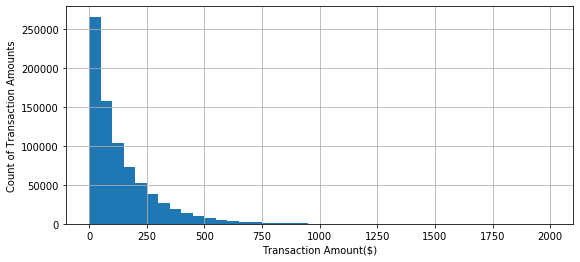

In [22]:
transplot = plt.figure(figsize = (20, 4))
ax1 = transplot.add_subplot(121)
trnz2.transactionAmount.hist(bins = range(0, 2050, 50), ax = ax1);
plt.xlabel('Transaction Amount($)');
plt.ylabel('Count of Transaction Amounts');

- the histogram of the transaction amount is largely right-skewed with a long right tail, largely following a log distribution
- most of the density is for transaction amounts less than 500, which leads me to hypothesize that most of these transactions are for everyday consumer products, entertainment, travel and billpay transactions as opposed to larger transactions like rent and loan payments
- it is odd that there are transactions with a value of 0 -> could that be something that isnt actually a purchase but still counts as a "transaction"?
- because of this distribution's shape, it should transform to a relatively normal distribution if we apply the log transformation, which could help in specifying variables in our model if we use a logistic regression model
- another thing to note is that, because we'll be using this data to build a fraud model and most transactions seem like everyday purchases in that they're under \\$500, maybe the transactions over a certain dollar value, e.g. \\$1000, are more likely to be fraudulent

In [23]:
trnz2['transactionAmount_log'] = trnz2.transactionAmount.apply(lambda x: np.log(x+0.01)) #have to shift by small constant bc 0 is undefined for the log distribution

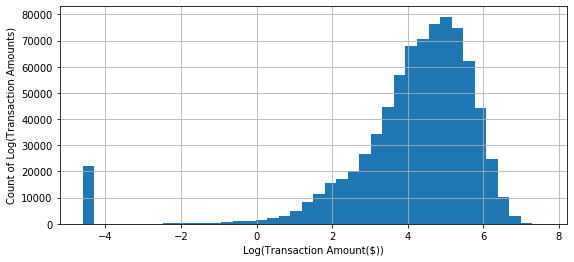

In [24]:
transplot2 = plt.figure(figsize = (20, 4))
ax1 = transplot2.add_subplot(121)
trnz2.transactionAmount_log.hist(bins = 40, ax = ax1);
plt.xlabel('Log(Transaction Amount($))');
plt.ylabel('Count of Log(Transaction Amounts)');

In [25]:
np.log(0.01)

-4.605170185988091

- the log transformed transaction amount is not quite normal and has a density below -4 corresponding to the shifted value of 0

# Question 3: Data Wrangling

- reversed transaction, where a purchase is followed by a reversal
- multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span

- Can you programmatically identify reversed and multi-swipe transactions?
- What total number of transactions and total dollar amount do you estimate for the reversed transactions? For the multi-swipe transactions? (please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts)
- Did you find anything interesting about either kind of transaction?

In [26]:
trnz2.head(2) #get column names to use in reversal and multiswipe transactions

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dt,currentExpDate_dt,accountOpenDate_dt,dateOfLastAddressChange_dt,transactionAmount_log
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False,2016-08-13 14:27:32,2023-06-01,2015-03-14,2015-03-14,4.590665
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False,2016-10-11 05:05:54,2024-02-01,2015-03-14,2015-03-14,4.311068


In [27]:
#what is in transactionType?
trnz2.transactionType.unique()

array(['PURCHASE', 'ADDRESS_VERIFICATION', 'REVERSAL', 'blank'],
      dtype=object)

reversal is already listed but multiswipe is not

In [28]:
# identify reversed and multiswipe transactions by sort dataset by account, customer, card, puchasetime
# if next transactionAmount is the same as the previous and from the same merchant that would mean a reversal 
# if the next transaction(s) have the same amount as the previous and is from the same merchant that would identify multi-swipe

trnz3 = trnz2.sort_values(by = ['accountNumber', 'customerId', 'cardLast4Digits', 'transactionDateTime_dt'], ascending = True).reset_index(drop = True)

In [29]:
#check range of transactionDateTime to pick value to impute nulls with
trnz3.transactionDateTime_dt.describe()

count                  786363
unique                 776637
top       2016-12-25 14:04:15
freq                        4
first     2016-01-01 00:01:02
last      2016-12-30 23:59:45
Name: transactionDateTime_dt, dtype: object

In [30]:
trnz3['accountNumber_shift'] = trnz3.accountNumber.shift(periods = 1, axis = 'rows', fill_value = -99)
trnz3['customerId_shift'] = trnz3.customerId.shift(periods = 1, axis = 'rows', fill_value = -99)
trnz3['cardLast4Digits_shift'] = trnz3.cardLast4Digits.shift(periods = 1, axis = 'rows', fill_value = -99)
trnz3['transactionDateTime_dt_shift'] = trnz3.transactionDateTime_dt.shift(periods = 1, axis = 'rows', fill_value = pd.to_datetime('2000-01-01 00:00:00', format = '%Y-%m-%d %H:%M:%S'))
trnz3['transactionAmount_shift'] = trnz3.transactionAmount.shift(periods = 1, axis = 'rows', fill_value = -99)
trnz3['transactionType_shift'] = trnz3.transactionType.shift(periods = 1, axis = 'rows', fill_value = 'blank')
trnz3['merchantName_shift'] = trnz3.merchantName.shift(periods = 1, axis = 'rows', fill_value = 'blank')

In [31]:
def find_duplicates(row):
    if (row['accountNumber'] == row['accountNumber_shift']) & (row['customerId'] == row['customerId_shift']) &\
        (row['cardLast4Digits'] == row['cardLast4Digits_shift']) &\
        (row['transactionDateTime_dt'] <= (row['transactionDateTime_dt_shift'] + datetime.timedelta(hours = 24))) &\
        (row['transactionType'] == 'REVERSAL') & (row['transactionType_shift'] == 'PURCHASE') &\
        (row['transactionAmount'] == row['transactionAmount_shift']) & (row['merchantName'] == row['merchantName_shift']):
        return 'reversed'
    elif (row['accountNumber'] == row['accountNumber_shift']) & (row['customerId'] == row['customerId_shift']) &\
        (row['cardLast4Digits'] == row['cardLast4Digits_shift']) &\
        (row['transactionDateTime_dt'] <= (row['transactionDateTime_dt_shift'] + datetime.timedelta(hours = 24))) &\
        (row['transactionType'] == 'PURCHASE') & (row['transactionType_shift'] == 'PURCHASE') &\
        (row['transactionAmount'] == row['transactionAmount_shift']) & (row['merchantName'] == row['merchantName_shift']):
        return 'multi_swipe'
    else:
        return 'non_duplicate'

In [32]:
trnz3['duplicateType'] = trnz3.apply(find_duplicates, axis = 1)

In [33]:
trnz3.duplicateType.value_counts(dropna = False)

non_duplicate    773519
multi_swipe        7342
reversed           5502
Name: duplicateType, dtype: int64

check some transactions

In [34]:
trnz3.loc[trnz3.duplicateType == 'reversed', ['cardLast4Digits', 'transactionAmount']].sample(5)

,cardLast4Digits,transactionAmount
265828,593,15.78
539912,5426,24.67
186215,2834,101.55
619566,1241,27.25
16645,3624,49.80


In [35]:
trnz3.loc[ (trnz3.cardLast4Digits == 9395) & (trnz3.transactionAmount == 9.68)] #looks right - same amount, same merchant, seconds from each other

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dt,currentExpDate_dt,accountOpenDate_dt,dateOfLastAddressChange_dt,transactionAmount_log,accountNumber_shift,customerId_shift,cardLast4Digits_shift,transactionDateTime_dt_shift,transactionAmount_shift,transactionType_shift,merchantName_shift,duplicateType
632497,810471359,810471359,5000,1443.23,2016-01-15T13:46:32,9.68,apple.com,US,US,09,08,online_retail,11/2028,2015-11-03,2015-11-03,713,713,9395,PURCHASE,3556.77,False,False,False,2016-01-15 13:46:32,2028-11-01,2015-11-03,2015-11-03,2.271094,810471359,810471359,9395,2016-01-15 06:48:23,184.26,REVERSAL,discount.com,non_duplicate
632498,810471359,810471359,5000,1433.55,2016-01-15T13:48:44,9.68,apple.com,US,US,09,08,online_retail,11/2028,2015-11-03,2015-11-03,713,713,9395,REVERSAL,3566.45,False,False,False,2016-01-15 13:48:44,2028-11-01,2015-11-03,2015-11-03,2.271094,810471359,810471359,9395,2016-01-15 13:46:32,9.68,PURCHASE,apple.com,reversed


In [36]:
trnz3.loc[ (trnz3.cardLast4Digits == 4609) & (trnz3.transactionAmount == 62.52)] #looks right - same amount, same merchant, seconds from each other

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dt,currentExpDate_dt,accountOpenDate_dt,dateOfLastAddressChange_dt,transactionAmount_log,accountNumber_shift,customerId_shift,cardLast4Digits_shift,transactionDateTime_dt_shift,transactionAmount_shift,transactionType_shift,merchantName_shift,duplicateType
33901,142263758,142263758,2500,1294.95,2016-10-17T01:15:42,62.52,Next Day eCards,US,US,05,01,online_gifts,07/2030,2013-09-19,2016-02-03,522,522,4609,PURCHASE,1205.05,False,False,False,2016-10-17 01:15:42,2030-07-01,2013-09-19,2016-02-03,4.135646,142263758,142263758,4609,2016-10-16 21:00:34,155.63,PURCHASE,williamssonoma.com,non_duplicate
33902,142263758,142263758,2500,1232.43,2016-10-17T01:17:07,62.52,Next Day eCards,US,US,05,01,online_gifts,07/2030,2013-09-19,2016-02-03,522,522,4609,REVERSAL,1267.57,False,False,False,2016-10-17 01:17:07,2030-07-01,2013-09-19,2016-02-03,4.135646,142263758,142263758,4609,2016-10-17 01:15:42,62.52,PURCHASE,Next Day eCards,reversed


In [37]:
trnz3.loc[ (trnz3.cardLast4Digits == 4165) & (trnz3.transactionAmount == 232.20)] #looks right - same amount, same merchant, seconds from each other

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dt,currentExpDate_dt,accountOpenDate_dt,dateOfLastAddressChange_dt,transactionAmount_log,accountNumber_shift,customerId_shift,cardLast4Digits_shift,transactionDateTime_dt_shift,transactionAmount_shift,transactionType_shift,merchantName_shift,duplicateType
758045,957964653,957964653,15000,11791.95,2016-10-04T18:42:28,232.2,walmart.com,US,US,05,01,online_retail,12/2026,2015-10-12,2015-10-12,784,784,4165,PURCHASE,3208.05,False,False,False,2016-10-04 18:42:28,2026-12-01,2015-10-12,2015-10-12,5.447642,957964653,957964653,4165,2016-09-23 23:45:48,58.97,PURCHASE,Sunoco Gas #316345,non_duplicate
758046,957964653,957964653,15000,11559.75,2016-10-04T18:43:58,232.2,walmart.com,US,US,05,01,online_retail,12/2026,2015-10-12,2015-10-12,784,784,4165,REVERSAL,3440.25,False,False,False,2016-10-04 18:43:58,2026-12-01,2015-10-12,2015-10-12,5.447642,957964653,957964653,4165,2016-10-04 18:42:28,232.20,PURCHASE,walmart.com,reversed


reversed transactions look right so now lets check multi_swipe

In [38]:
trnz3.loc[trnz3.duplicateType == 'multi_swipe', ['cardLast4Digits', 'transactionAmount']].sample(5)

,cardLast4Digits,transactionAmount
608713,5534,8.58
290313,5845,527.50
543673,4864,309.45
34200,7831,149.99
34964,5093,233.27


In [39]:
trnz3.loc[ (trnz3.cardLast4Digits == 9685) & (trnz3.transactionAmount == 113.57)] #looks right - same amount, same merchant, seconds from each other

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dt,currentExpDate_dt,accountOpenDate_dt,dateOfLastAddressChange_dt,transactionAmount_log,accountNumber_shift,customerId_shift,cardLast4Digits_shift,transactionDateTime_dt_shift,transactionAmount_shift,transactionType_shift,merchantName_shift,duplicateType
208151,346419123,346419123,7500,7500.00,2016-02-01T21:54:38,113.57,Starbucks #516830,US,US,02,01,fastfood,06/2026,2015-04-14,2015-04-14,149,149,9685,PURCHASE,0.00,True,False,False,2016-02-01 21:54:38,2026-06-01,2015-04-14,2015-04-14,4.732507,346419123,346419123,9685,2016-01-31 17:26:20,3.56,REVERSAL,discount.com,non_duplicate
208152,346419123,346419123,7500,7386.43,2016-02-01T21:57:16,113.57,Starbucks #516830,US,US,02,01,fastfood,06/2026,2015-04-14,2015-04-14,149,149,9685,PURCHASE,113.57,True,False,False,2016-02-01 21:57:16,2026-06-01,2015-04-14,2015-04-14,4.732507,346419123,346419123,9685,2016-02-01 21:54:38,113.57,PURCHASE,Starbucks #516830,multi_swipe
208153,346419123,346419123,7500,7272.86,2016-02-01T21:58:18,113.57,Starbucks #516830,US,US,02,01,fastfood,06/2026,2015-04-14,2015-04-14,149,149,9685,PURCHASE,227.14,True,False,False,2016-02-01 21:58:18,2026-06-01,2015-04-14,2015-04-14,4.732507,346419123,346419123,9685,2016-02-01 21:57:16,113.57,PURCHASE,Starbucks #516830,multi_swipe


In [40]:
trnz3.loc[ (trnz3.cardLast4Digits == 9102) & (trnz3.transactionAmount == 151.64)] #looks right - same amount, same merchant, seconds from each other

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dt,currentExpDate_dt,accountOpenDate_dt,dateOfLastAddressChange_dt,transactionAmount_log,accountNumber_shift,customerId_shift,cardLast4Digits_shift,transactionDateTime_dt_shift,transactionAmount_shift,transactionType_shift,merchantName_shift,duplicateType
714068,894938833,894938833,15000,2371.86,2016-12-12T11:00:25,151.64,Walgreens #808671,US,US,09,01,health,06/2020,2014-11-05,2016-11-13,689,689,9102,PURCHASE,12628.14,True,False,False,2016-12-12 11:00:25,2020-06-01,2014-11-05,2016-11-13,5.021575,894938833,894938833,9102,2016-12-12 10:38:19,377.18,PURCHASE,NYSC #331326,non_duplicate
714069,894938833,894938833,15000,2220.22,2016-12-12T11:01:18,151.64,Walgreens #808671,US,US,09,01,health,06/2020,2014-11-05,2016-11-13,689,689,9102,PURCHASE,12779.78,True,False,False,2016-12-12 11:01:18,2020-06-01,2014-11-05,2016-11-13,5.021575,894938833,894938833,9102,2016-12-12 11:00:25,151.64,PURCHASE,Walgreens #808671,multi_swipe


### estimated total number of reversed and multi-swipe transactions

In [41]:
trnz3.duplicateType.value_counts(dropna = False)

non_duplicate    773519
multi_swipe        7342
reversed           5502
Name: duplicateType, dtype: int64

### estimated dollar amounts for reversed and multi_swipe transactions

In [42]:
trnz3.groupby('duplicateType')['transactionAmount'].sum().apply(lambda x: '${:,.2f}'.format(x))

duplicateType
multi_swipe        $1,087,165.85
non_duplicate    $105,808,565.16
reversed             $824,826.52
Name: transactionAmount, dtype: object

### \\$824K in reversed transactions and \\$1.08M for multi swipe transactions

is there anything interesting about the reversed and multi-swipe transactions relative to the non-duplicate transactions?
- transactionAmount?
- particular merchant categories?
- particular days?
- merchant locations?

duplicateType x transactionAmount

In [170]:
trnz3.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'isFraud', 'transactionDateTime_dt',
       'currentExpDate_dt', 'accountOpenDate_dt', 'dateOfLastAddressChange_dt',
       'transactionAmount_log', 'accountNumber_shift', 'customerId_shift',
       'cardLast4Digits_shift', 'transactionDateTime_dt_shift',
       'transactionAmount_shift', 'transactionType_shift',
       'merchantName_shift', 'duplicateType', 'trns_weekday', 'trns_hr',
       'ran_num', 'train_test'],
      dtype='object')

In [174]:
merch_dup_agg = trn.groupby(['merchantName', 'duplicateType']).size().reset_index()
merch_dup_agg.columns = ['merchantName', 'duplicateType', 'count']
merch_dup_pvt = merch_dup_agg.pivot_table(values = 'count', index = 'merchantName', columns = 'duplicateType', fill_value = 0).reset_index()
merch_dup_pvt['total_count'] = merch_dup_pvt.multi_swipe + merch_dup_pvt.non_duplicate + merch_dup_pvt.reversed
merch_dup_pvt['pct_reversed'] = merch_dup_pvt.reversed / merch_dup_pvt.total_count
merch_dup_pvt['pct_multi_swipe'] = merch_dup_pvt.multi_swipe / merch_dup_pvt.total_count
merch_dup_pvt['pct_duplicate'] = (merch_dup_pvt.reversed + merch_dup_pvt.multi_swipe) / merch_dup_pvt.total_count

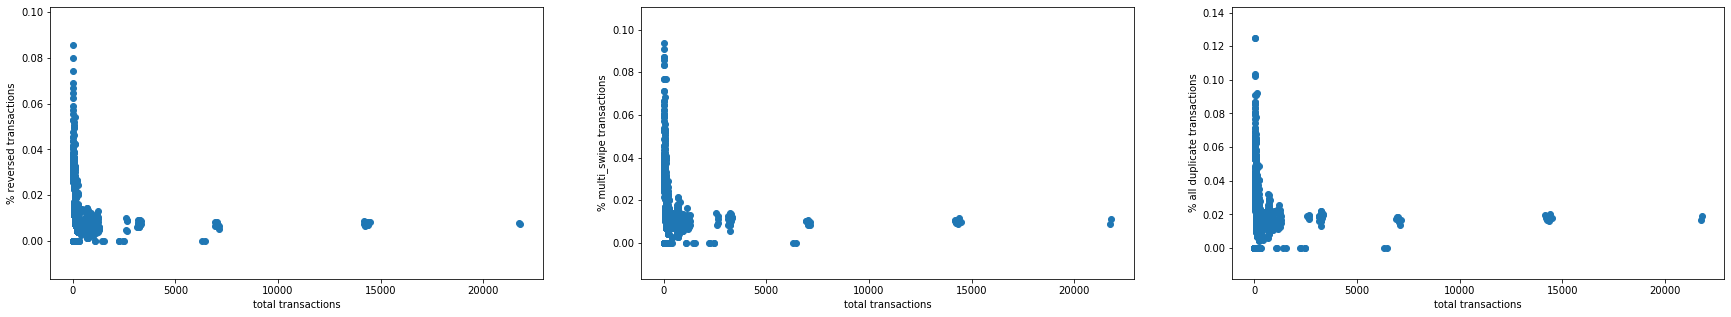

In [175]:
dup_fig = plt.figure(figsize = (30, 5))
ax1 = dup_fig.add_subplot(131)
plt.scatter(merch_dup_pvt.total_count, merch_dup_pvt.pct_reversed)
plt.xlabel('total transactions')
plt.ylabel('% reversed transactions');

ax2 = dup_fig.add_subplot(132)
plt.scatter(merch_dup_pvt.total_count, merch_dup_pvt.pct_multi_swipe)
plt.xlabel('total transactions')
plt.ylabel('% multi_swipe transactions');

ax3 = dup_fig.add_subplot(133)
plt.scatter(merch_dup_pvt.total_count, merch_dup_pvt.pct_duplicate)
plt.xlabel('total transactions')
plt.ylabel('% all duplicate transactions');

- because the percentage of reversed, multi-swipe and duplicate transactions is only higher for merchants with less transactions and rarely above 10%, there doesn't appear to be a subset of merchants with an exceptionally high percentage of reversed or duplicate transactions
- there are some merchants without any duplicate or multi-swipe transactions -> who are they?

In [178]:
merch_dup_pvt.loc[ (merch_dup_pvt.pct_duplicate == 0) & (merch_dup_pvt.total_count >= 200)]

duplicateType,merchantName,multi_swipe,non_duplicate,reversed,total_count,pct_reversed,pct_multi_swipe,pct_duplicate
43,Apple iTunes,0,6453,0,6453,0.0,0.0,0.0
340,Daily Fresh,0,1078,0,1078,0.0,0.0,0.0
341,DailyOmnivore,0,1518,0,1518,0.0,0.0,0.0
682,GreenCook,0,1420,0,1420,0.0,0.0,0.0
1107,Mobil Gas #235527,0,222,0,222,0.0,0.0,0.0
1120,Mobil Gas #841292,0,262,0,262,0.0,0.0,0.0
1121,Mobil Gas #851671,0,212,0,212,0.0,0.0,0.0
1123,Mobil Gas #864408,0,273,0,273,0.0,0.0,0.0
1125,Mobil Gas #917403,0,307,0,307,0.0,0.0,0.0
1130,MyApron,0,1094,0,1094,0.0,0.0,0.0


In [43]:
trnz3.groupby('duplicateType')['transactionAmount'].describe()

,count,mean,std,min,25%,50%,75%,max
duplicateType,,,,,,,,
multi_swipe,7342.0,148.074891,147.997143,0.01,41.5725,101.265,205.810,1394.19
non_duplicate,773519.0,136.788579,147.675165,0.00,33.5400,87.650,191.230,2011.54
reversed,5502.0,149.913944,153.233509,0.09,41.0700,104.305,204.295,1338.25


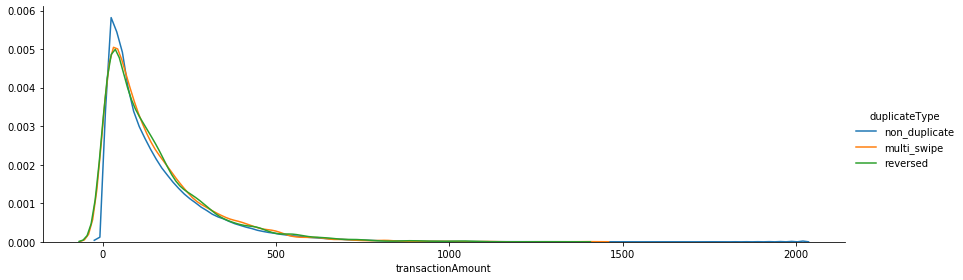

In [44]:
dup_amt = sns.FacetGrid(data = trnz3, hue = 'duplicateType', sharex = True, sharey = False, height = 4, aspect = 3)
dup_amt = dup_amt.map(sns.kdeplot, 'transactionAmount').add_legend();

- mean transaction amounts for reversed and multi_swipe transactions are a little higher but this doesnt look to be a significant difference and not one that we would expect -> we could do a formal non-parametric kruskall wallis test but that seems unnecessary here because we're just doing some exploration

merchant types

In [179]:
merch_cat_agg = trn.groupby(['merchantCategoryCode', 'duplicateType']).size().reset_index()
merch_cat_agg.columns = ['merchantCategoryCode', 'duplicateType', 'count']
merch_cat_pvt = merch_cat_agg.pivot_table(values = 'count', index = 'merchantCategoryCode', columns = 'duplicateType', fill_value = 0).reset_index()
merch_cat_pvt['total_count'] = merch_cat_pvt.multi_swipe + merch_cat_pvt.non_duplicate + merch_cat_pvt.reversed
merch_cat_pvt['pct_reversed'] = merch_cat_pvt.reversed / merch_cat_pvt.total_count
merch_cat_pvt['pct_multi_swipe'] = merch_cat_pvt.multi_swipe / merch_cat_pvt.total_count
merch_cat_pvt['pct_duplicate'] = (merch_cat_pvt.reversed + merch_cat_pvt.multi_swipe) / merch_cat_pvt.total_count

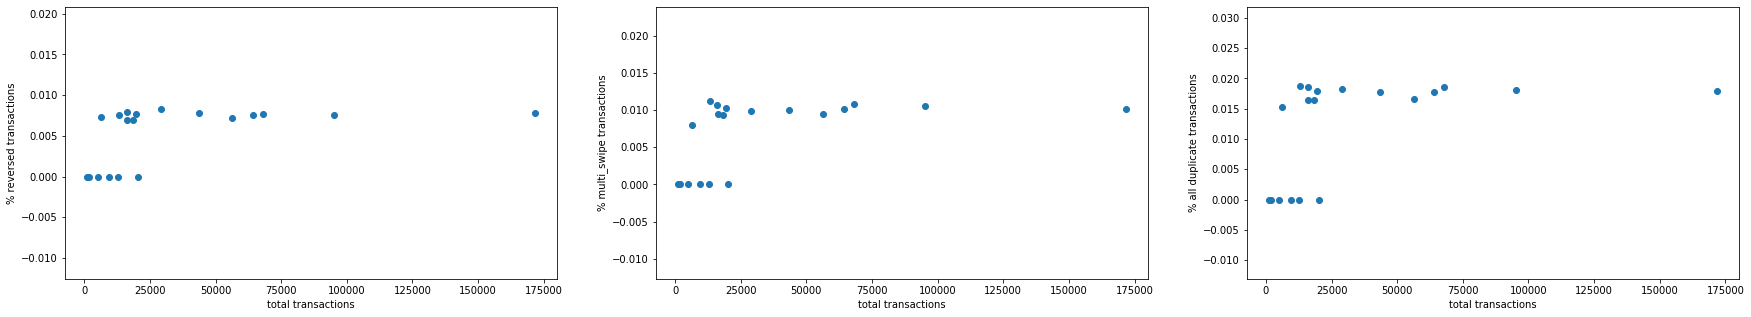

In [180]:
dup_fig2 = plt.figure(figsize = (30, 5))
ax1 = dup_fig2.add_subplot(131)
plt.scatter(merch_cat_pvt.total_count, merch_cat_pvt.pct_reversed)
plt.xlabel('total transactions')
plt.ylabel('% reversed transactions');

ax2 = dup_fig2.add_subplot(132)
plt.scatter(merch_cat_pvt.total_count, merch_cat_pvt.pct_multi_swipe)
plt.xlabel('total transactions')
plt.ylabel('% multi_swipe transactions');

ax3 = dup_fig2.add_subplot(133)
plt.scatter(merch_cat_pvt.total_count, merch_cat_pvt.pct_duplicate)
plt.xlabel('total transactions')
plt.ylabel('% all duplicate transactions');

In [181]:
merch_cat_pvt.loc[ merch_cat_pvt.pct_duplicate == 0]

duplicateType,merchantCategoryCode,multi_swipe,non_duplicate,reversed,total_count,pct_reversed,pct_multi_swipe,pct_duplicate
2,cable/phone,0,1170,0,1170,0.0,0.0,0.0
6,food_delivery,0,5110,0,5110,0.0,0.0,0.0
7,fuel,0,20327,0,20327,0.0,0.0,0.0
9,gym,0,1881,0,1881,0.0,0.0,0.0
12,mobileapps,0,12747,0,12747,0.0,0.0,0.0
15,online_subscriptions,0,9439,0,9439,0.0,0.0,0.0


there dont appear to be any patterns of duplicate or multi-swipe transactions occurring more often at particular kinds of merchants but it is interesting that these entire categories of merchants - cable/phone, food_delivery, fuel, gym, mobileapps and online_subscriptions don't have any duplicate transactions
    - gym, cable/phone and online_subscriptions are largely subscription services with most transactions likely automated, recurring transactions with the cardholder's card attributes
    - mobileapps and food_delivery are likely similar in that they have card information saved for future transactions
    - why fuel has no multi_swipe or duplicate transactions is odd because i would assume most if not all people are entering and removing their card for fuel purchases, unless a large portion or all of these transactions are done via the card stored on a user's phone?

lets check days or hours of the day for patterns of more duplicate transactions, i.e. at the end of the week or day are reversed or multi_swipe transactions more prevalent?

In [47]:
wkday_dict = {0:'Mon', 1:'Tues', 2:'Weds', 3:'Thurs', 4:'Fri', 5:'Sat', 6:'Sun'}
trnz3['trns_weekday'] = pd.Categorical(trnz3.transactionDateTime_dt.dt.date.apply(lambda x: x.weekday()).map(wkday_dict), 
                                       categories = ['Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat', 'Sun'], ordered = True)
trnz3['trns_hr'] = trnz3.transactionDateTime_dt.dt.hour

In [183]:
wkday_agg = trn.groupby(['trns_weekday', 'duplicateType']).size().reset_index()
wkday_agg.columns = ['trns_weekday', 'duplicateType', 'count']
wkday_pvt = wkday_agg.pivot_table(values = 'count', index = 'trns_weekday', columns = 'duplicateType', fill_value = 0).reset_index()
wkday_pvt['total_count'] = wkday_pvt.multi_swipe + wkday_pvt.non_duplicate + wkday_pvt.reversed
wkday_pvt['pct_reversed'] = wkday_pvt.reversed / wkday_pvt.total_count
wkday_pvt['pct_multi_swipe'] = wkday_pvt.multi_swipe / wkday_pvt.total_count
wkday_pvt['pct_duplicate'] = (wkday_pvt.reversed + wkday_pvt.multi_swipe) / wkday_pvt.total_count

In [184]:
wkday_pvt

duplicateType,trns_weekday,multi_swipe,non_duplicate,reversed,total_count,pct_reversed,pct_multi_swipe,pct_duplicate
0,Mon,935,93137,677,94749,0.007145,0.009868,0.017013
1,Tues,885,94051,629,95565,0.006582,0.009261,0.015843
2,Weds,878,93648,704,95230,0.007393,0.009220,0.016612
3,Thurs,885,93460,662,95007,0.006968,0.009315,0.016283
4,Fri,901,96066,695,97662,0.007116,0.009226,0.016342
5,Sat,897,93535,682,95114,0.007170,0.009431,0.016601
6,Sun,907,93213,658,94778,0.006943,0.009570,0.016512


In [185]:
hr_agg = trn.groupby(['trns_hr', 'duplicateType']).size().reset_index()
hr_agg.columns = ['trns_hr', 'duplicateType', 'count']
hr_pvt = hr_agg.pivot_table(values = 'count', index = 'trns_hr', columns = 'duplicateType', fill_value = 0).reset_index()
hr_pvt['total_count'] = hr_pvt.multi_swipe + hr_pvt.non_duplicate + hr_pvt.reversed
hr_pvt['pct_reversed'] = hr_pvt.reversed / hr_pvt.total_count
hr_pvt['pct_multi_swipe'] = hr_pvt.multi_swipe / hr_pvt.total_count
hr_pvt['pct_duplicate'] = (hr_pvt.reversed + hr_pvt.multi_swipe) / hr_pvt.total_count

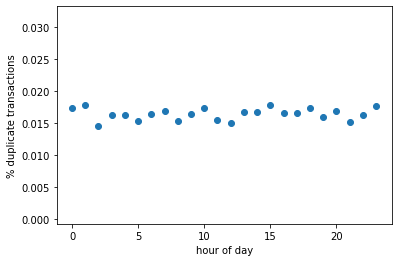

In [188]:
plt.scatter(hr_pvt.trns_hr, hr_pvt.pct_duplicate);
plt.xlabel('hour of day')
plt.ylabel('% duplicate transactions');

duplicate transactions dont have any pattern across weekdays or hours as they are uniformly distributed across days of the week for each transaction type

merchant geographies

In [50]:
dup_geo_df = trnz3.groupby(['duplicateType', 'merchantCountryCode']).size().reset_index()
dup_geo_df.columns = ['duplicateType', 'merchantCountryCode', 'transactions']

In [51]:
dup_geo_total = trnz3.groupby('duplicateType').size().reset_index()
dup_geo_total.columns = ['duplicateType', 'totalTransactions']

In [52]:
dup_geo_df2 = dup_geo_df.merge(dup_geo_total, on = 'duplicateType', how = 'inner')

In [53]:
dup_geo_df2['country_pct_transactions'] = np.round(dup_geo_df2.transactions / dup_geo_df2.totalTransactions, 3)

In [54]:
dup_geo_df2

,duplicateType,merchantCountryCode,transactions,totalTransactions,country_pct_transactions
0,multi_swipe,CAN,20,7342,0.003
1,multi_swipe,MEX,30,7342,0.004
2,multi_swipe,PR,11,7342,0.001
3,multi_swipe,US,7280,7342,0.992
4,multi_swipe,blank,1,7342,0.000
5,non_duplicate,CAN,2381,773519,0.003
6,non_duplicate,MEX,3083,773519,0.004
7,non_duplicate,PR,1537,773519,0.002
8,non_duplicate,US,765799,773519,0.990
9,non_duplicate,blank,719,773519,0.001


- there doesnt appear to be a notable relationship between merchantCountry and duplicate transactions either
- therefore, if there is an interesting relationship with duplicate transaction types we'd have to do more research to find it

# Question 4: Model

- Each of the transactions in the dataset has a field called isFraud. Please build a predictive model to determine whether a given transaction will be fraudulent or not. Use as much of the data as you like (or all of it).
- Provide an estimate of performance using an appropriate sample, and show your work.
- Please explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time)

Approach: assuming that this is a predictive model whose predictive performance outweighs interpreting coefficients to make recommendations related to variables in the model, particularly because fraud is the use-case, we'll fit a couple models to compare their performance
1. separate into training and test set - training to build the model and test to compare out-of-sample predictive performance
2. make some derived variables
3. perform some exploratory data analysis on explanatory variables as well as their relationship with the response
#### modeling algorithm/used and why
4. modelling
    - fit a couple models with different parameterizations and objective functions because it is hard to understand how these variables are represented in high dimensions and in combination with each other outside of fitting the model
        - regularized logistic regression for linear parameterization of explanatory variables
        - gradient boosted tree for tree structure and boosting capability to improve model based on misclassified cases
        - naive bayes for bayesian parameterization assuming conditional independence 

5. score models on test set and compare performance

#### 1. train and test split - 85/15 assuming that fraud will be a rare event to have enough cases in the training set to build model and relatively small test set

In [55]:
trnz3['ran_num'] = np.random.uniform(low = 0, high = 1, size = trnz3.shape[0])
trnz3['train_test'] = np.where(trnz3.ran_num >= 0.15, 'train', 'test')

In [56]:
trn = trnz3.loc[ trnz3.train_test == 'train']

In [57]:
#proportion of fraudulent cases in training set
np.round(trn.isFraud.value_counts(dropna = False) / trn.shape[0], 3)

False    0.984
True     0.016
Name: isFraud, dtype: float64

1.6% of rows is fraudulent in the training set

#### 2. make some derived variables

In [58]:
trn.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dt,currentExpDate_dt,accountOpenDate_dt,dateOfLastAddressChange_dt,transactionAmount_log,accountNumber_shift,customerId_shift,cardLast4Digits_shift,transactionDateTime_dt_shift,transactionAmount_shift,transactionType_shift,merchantName_shift,duplicateType,trns_weekday,trns_hr,ran_num,train_test
0,100088067,100088067,50000,49748.44,2016-01-17T15:41:46,378.67,Mobile eCards,US,US,05,01,online_gifts,11/2031,2014-01-09,2014-01-09,402,402,2077,PURCHASE,251.56,False,False,False,2016-01-17 15:41:46,2031-11-01,2014-01-09,2014-01-09,5.936692,-99,-99,-99,2000-01-01 00:00:00,-99.00,blank,blank,non_duplicate,Sun,15,0.844174,train
1,100088067,100088067,50000,49792.33,2016-02-08T06:09:12,259.44,Blue Mountain eCards,US,US,05,01,online_gifts,01/2028,2014-01-09,2014-01-09,402,402,2077,PURCHASE,207.67,False,False,False,2016-02-08 06:09:12,2028-01-01,2014-01-09,2014-01-09,5.558564,100088067,100088067,2077,2016-01-17 15:41:46,378.67,PURCHASE,Mobile eCards,non_duplicate,Mon,6,0.276158,train
2,100088067,100088067,50000,49532.89,2016-02-09T18:36:53,32.50,EZ Putt Putt #804489,US,US,09,01,entertainment,07/2026,2014-01-09,2014-01-09,402,402,2077,PURCHASE,467.11,True,False,False,2016-02-09 18:36:53,2026-07-01,2014-01-09,2014-01-09,3.481548,100088067,100088067,2077,2016-02-08 06:09:12,259.44,PURCHASE,Blue Mountain eCards,non_duplicate,Tues,18,0.784981,train
3,100088067,100088067,50000,49477.33,2016-02-13T20:17:41,56.05,Fresh Flowers,US,US,05,01,online_gifts,01/2033,2014-01-09,2014-01-09,402,402,2077,PURCHASE,522.67,False,False,False,2016-02-13 20:17:41,2033-01-01,2014-01-09,2014-01-09,4.026423,100088067,100088067,2077,2016-02-09 18:36:53,32.50,PURCHASE,EZ Putt Putt #804489,non_duplicate,Sat,20,0.547659,train
5,100088067,100088067,50000,49769.86,2016-03-25T21:32:36,161.45,Fresh eCards,US,US,05,01,online_gifts,07/2026,2014-01-09,2014-01-09,402,402,2077,PURCHASE,230.14,False,False,False,2016-03-25 21:32:36,2026-07-01,2014-01-09,2014-01-09,5.084257,100088067,100088067,2077,2016-03-12 12:55:28,97.79,PURCHASE,Dinosaur Sandwitch Bar #960325,non_duplicate,Fri,21,0.304945,train


what do the values in acqCountry and merchantCountyCode look like?

In [59]:
trn.acqCountry.value_counts(dropna = False)

US       658161
blank      3933
MEX        2661
CAN        2046
PR         1304
Name: acqCountry, dtype: int64

In [60]:
trn.merchantCountryCode.value_counts(dropna = False)

US       661425
MEX        2671
CAN        2047
PR         1322
blank       640
Name: merchantCountryCode, dtype: int64

- % creditUtilization = cardBalance / creditLimit
- acq country = merchant country
- time since account open
- time since last address change (potentially last time account information was updated, potentially including security settings like password making fraud harder)
- cardCVV = enteredCVV
- transaction month

In [61]:
trn.transactionDateTime_dt.head().apply(lambda x: x.month)

0    1
1    2
2    2
3    2
5    3
Name: transactionDateTime_dt, dtype: int64

In [62]:
trn['creditUtil'] = trn.currentBalance / trn.creditLimit
trn['acqEqMerchCountry'] = np.where(trn.acqCountry == trn.merchantCountryCode, 'Yes', 'No')
trn['daysSinceAcctOpen'] = (trn.transactionDateTime_dt.dt.date - trn.accountOpenDate_dt.dt.date).dt.days
trn['daysSinceAddressChange'] = (trn.transactionDateTime_dt.dt.date - trn.dateOfLastAddressChange_dt.dt.date).dt.days
trn['cvvEqual'] = np.where(trn.cardCVV == trn.enteredCVV, 'Yes' ,'No')

#map months to categories so categorical representation is used instead of continuous in the model
month_dict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
trn['transactionMonth'] = pd.Categorical(trn.transactionDateTime_dt.apply(lambda x: x.month).map(month_dict),
                                         categories = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered = True)

#### 3. do some exploratory data analysis on individual variables and derived variables vs the response variable

In [63]:
trn.isFraud.unique()

array([False,  True])

In [64]:
# create response variable for model
trn['fraud'] = np.where(trn.isFraud == True, 1, 0)

continuous variables first

In [65]:
trn.select_dtypes(include = ['int64', 'float64']).columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionAmount', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'currentBalance', 'transactionAmount_log', 'accountNumber_shift',
       'customerId_shift', 'cardLast4Digits_shift', 'transactionAmount_shift',
       'trns_hr', 'ran_num', 'creditUtil', 'daysSinceAcctOpen',
       'daysSinceAddressChange'],
      dtype='object')

In [66]:
cont_desc_df = trn.groupby('isFraud')['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance', 'transactionAmount_log', 'trns_hr', 'creditUtil', 'daysSinceAcctOpen', 'daysSinceAddressChange'].describe().stack().reset_index()
cont_desc_df.columns = ['isFraud', 'stat', 'creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance', 'transactionAmount_log', 'trns_hr', 'creditUtil', 'daysSinceAcctOpen', 'daysSinceAddressChange']
cont_desc_df.sort_values(by = ['stat', 'isFraud'])

,isFraud,stat,creditLimit,availableMoney,transactionAmount,currentBalance,transactionAmount_log,trns_hr,creditUtil,daysSinceAcctOpen,daysSinceAddressChange
4,False,25%,5000.000000,1078.145000,33.260000,688.560000,3.504656,6.000000,0.172377,430.000000,28.000000
12,True,25%,5000.000000,1079.577500,86.062500,830.892500,4.455190,6.000000,0.197082,425.000000,23.000000
5,False,50%,7500.000000,3184.670000,86.820000,2446.340000,4.463952,12.000000,0.472556,680.000000,160.000000
13,True,50%,7500.000000,3117.685000,176.410000,2809.115000,5.172868,12.000000,0.500196,667.000000,125.500000
6,False,75%,15000.000000,7500.000000,189.580000,5280.855000,5.244864,18.000000,0.730820,1111.000000,612.000000
14,True,75%,15000.000000,7539.110000,310.130000,5748.595000,5.737024,17.000000,0.749062,1007.750000,552.000000
0,False,count,657575.000000,657575.000000,657575.000000,657575.000000,657575.000000,657575.000000,657575.000000,657575.000000,657575.000000
8,True,count,10530.000000,10530.000000,10530.000000,10530.000000,10530.000000,10530.000000,10530.000000,10530.000000,10530.000000
7,False,max,50000.000000,50000.000000,2011.540000,47496.320000,7.606661,23.000000,4.722200,9990.000000,9990.000000
15,True,max,50000.000000,50000.000000,1608.350000,47473.940000,7.382970,23.000000,3.457560,9890.000000,9890.000000


- mean transaction amounts are higher for fraud, but maximum is lower and standard deviation is higher -> interesting
- days since account open is slightly less the fraud transactions
- some difference between means in daysSinceAddressChange
- other variables variables dont reveal much difference in distribution between fraudulent transactions and not

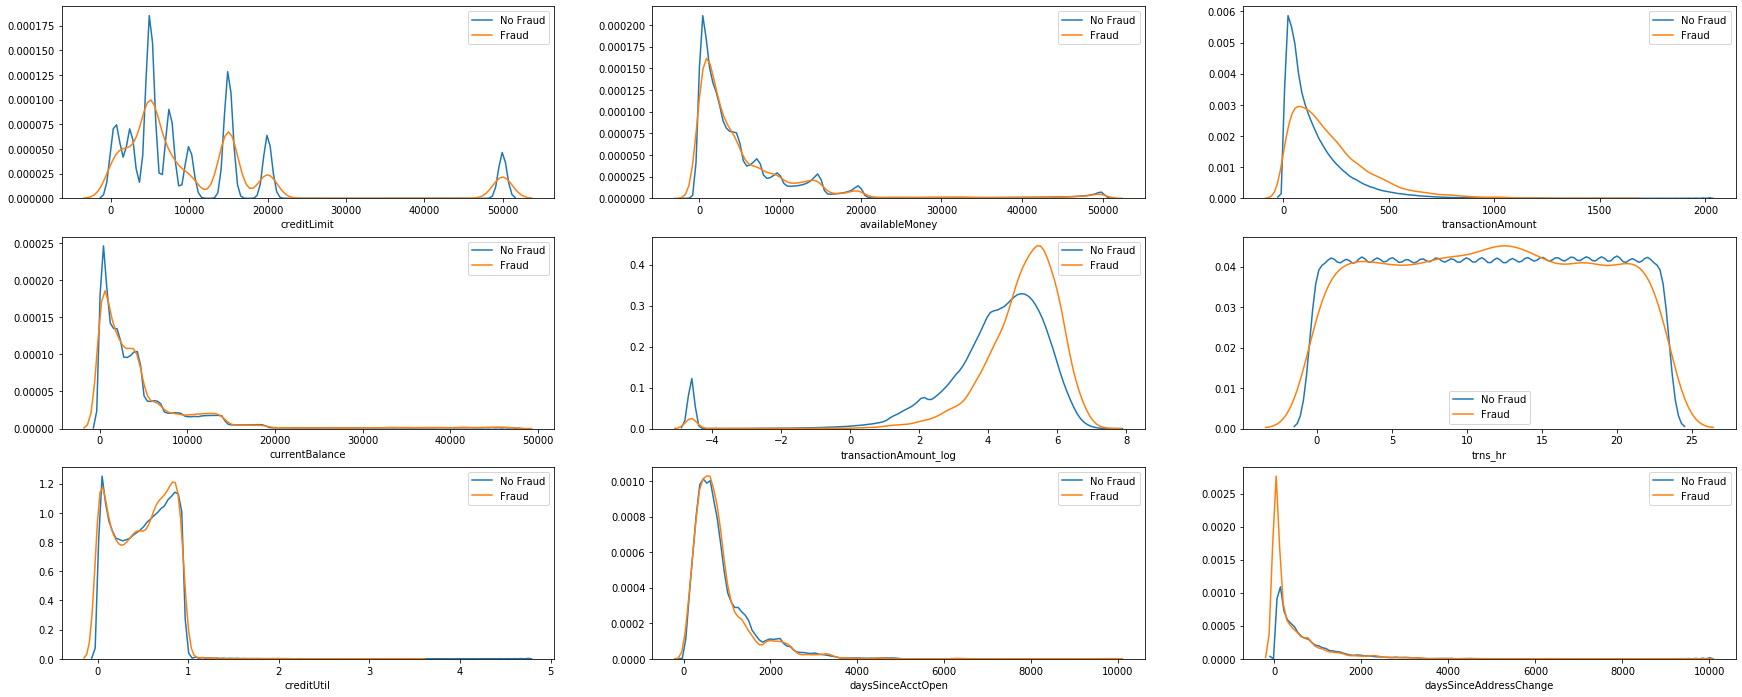

In [67]:
#continuous variables vs isFraud - 
cont_vars = ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance', 'transactionAmount_log', 
    'trns_hr', 'creditUtil', 'daysSinceAcctOpen', 'daysSinceAddressChange']

cont_fig = plt.figure(figsize = (30, 12))

for c in cont_vars:

    ax = cont_fig.add_subplot(3,3,(cont_vars.index(c) + 1))
    sns.distplot(trn.loc[ trn.fraud == 0, c], label = 'No Fraud', hist = False)
    sns.distplot(trn.loc[ trn.fraud == 1, c], label = 'Fraud', hist = False)
    plt.legend();

- similar to the summary statistics we saw above, transactionAmount and transactionAmoung_log show some differences in their distribution
- another variable whose distribution is slightly different by fraud/no fraud is trns_hr (hour of transaction), which shows slightly more central tendency for fraudulent transactions than non-fraudulent around hour 12-13 whereas non-fraudulent transactions have a virtually uniform distribution
#### - therefore, transactionAmount and hour of transaction appear to be useful for predicting fraudulent cases

categorical variables versus fraud

In [68]:
trn.select_dtypes(include = ['O']).columns

Index(['transactionDateTime', 'merchantName', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'transactionType', 'transactionType_shift',
       'merchantName_shift', 'duplicateType', 'train_test',
       'acqEqMerchCountry', 'cvvEqual'],
      dtype='object')

merchantName has over 2K values so examine this separately with summary statistics

In [166]:
merchName_agg = trn.groupby(['merchantName', 'isFraud']).size().reset_index()
merchName_agg.columns = ['merchantName', 'isFraud', 'count']
merchName_pvt = merchName_agg.pivot_table(values = 'count', index = 'merchantName', columns = 'isFraud', fill_value = 0).reset_index()
merchName_pvt.columns = ['merchantName', 'NotFraud_count', 'Fraud_count']
merchName_pvt['total_count'] = merchName_pvt.Fraud_count + merchName_pvt.NotFraud_count
merchName_pvt['pct_fraud'] = merchName_pvt.Fraud_count / merchName_pvt.total_count

In [167]:
merchName_pvt.head()

,merchantName,NotFraud_count,Fraud_count,total_count,pct_fraud
0,1st BBQ,700,11,711,0.015471
1,1st Deli,669,4,673,0.005944
2,1st Pub,670,20,690,0.028986
3,1st Restaurant,741,7,748,0.009358
4,1st Sandwitch Bar #119707,649,9,658,0.013678


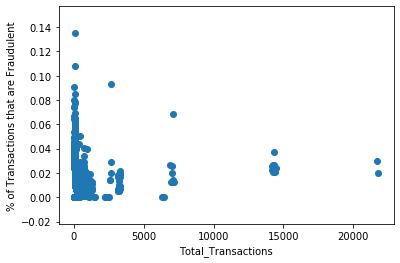

In [169]:
plt.scatter(merchName_pvt.total_count, merchName_pvt.pct_fraud);
plt.xlabel('Total_Transactions');
plt.ylabel('% of Transactions that are Fraudulent');

because there aren't merchants that appear to have a notably higher percentage of fraudulent transactions and there are 2K+ levels of this variable, including it in the model would lead to significantly more processing time to create all of the indicator variables for the model, so we'll exclude it from the model

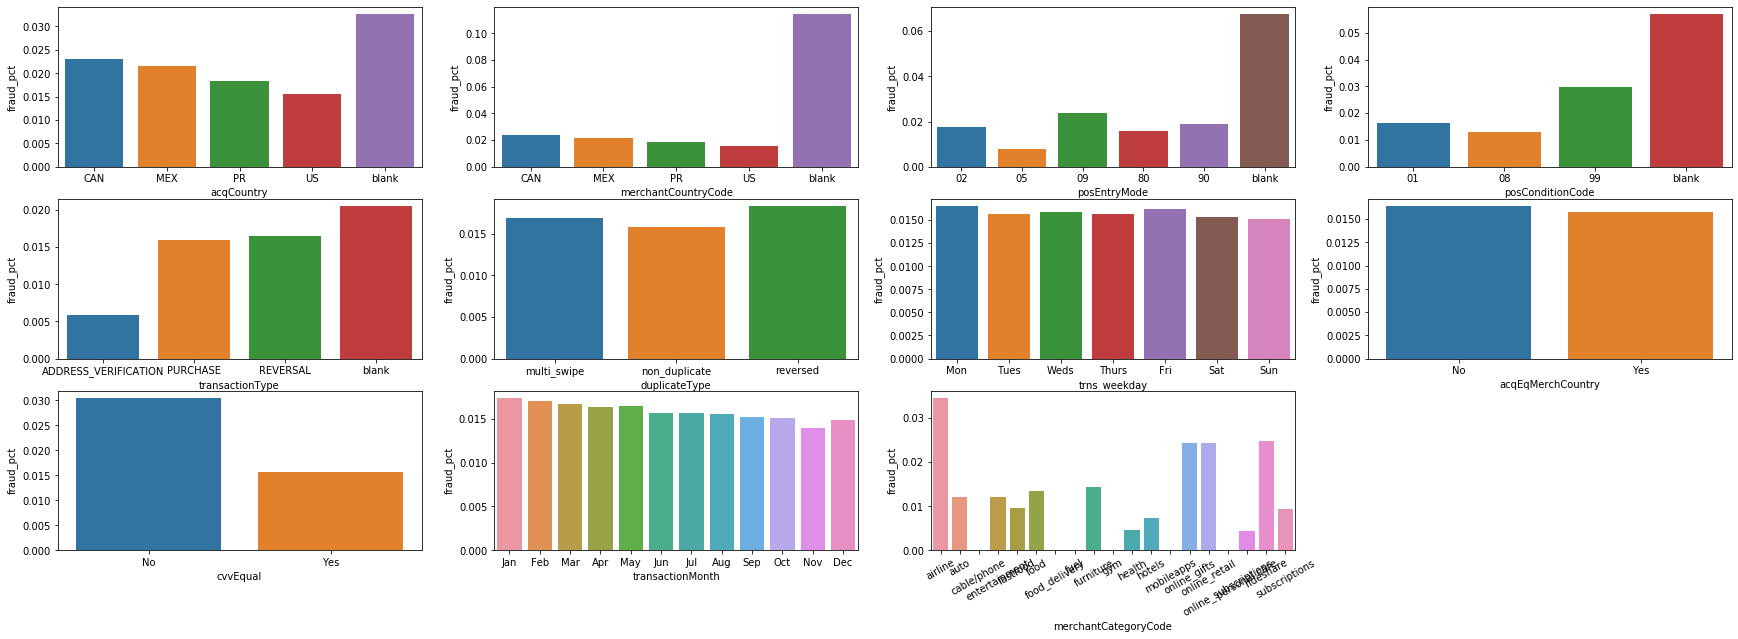

In [69]:
cat_vars = ['acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'transactionType', 'duplicateType', 
            'trns_weekday', 'acqEqMerchCountry', 'cvvEqual', 'transactionMonth', 'merchantCategoryCode']

cat_fig = plt.figure(figsize = (30, 10))

for c in cat_vars:
    
    test_df = pd.crosstab(trn[c], trn.fraud).reset_index()
    test_df.columns = [c, 'nofraud', 'fraud']
    test_df['fraud_pct'] =  test_df.fraud / (test_df.fraud + test_df.nofraud)
    
    if c == 'merchantCategoryCode':
    
        ax = cat_fig.add_subplot(3,4,(cat_vars.index(c)+1))
        sns.barplot(data = test_df, x = c, y = 'fraud_pct');
        plt.xticks(rotation = 30);
        
    else:
        
        ax = cat_fig.add_subplot(3,4,(cat_vars.index(c)+1))
        sns.barplot(data = test_df, x = c, y = 'fraud_pct');

#### - there are plenty of interesting differences among categorical variables
- blank values have a notably (maybe significant, maybe not) higher percentage of fraudulent transactions within acqCountry, merchantCountryCode, posEntryMode, posConditionCode and transactionType, which isn't surprising
- instances where the acquisition country doesnt equal the merchant country doesnt lead to a higher percentage of fraudulent transactions
- instances where the cvv isnt equal has a likelihood of being fraudulent twice as much as not fraudulent
- airlines, mobileapps, online_gifts and rideshare have notably higher percentages of fraudulent transactions as well

#### - day of week, month and duplicate type dont appear to have notable differences in percentage of fraudulent transactions

#### what questions do you have?
- what do the different values of posEntryModel delineate?
- what do the different values of posConditionCode encompass?
- how is a transaction reported to be fraudulent? 
- how was this sample of transactions chosen to build the model?

### 4. model fitting

- a. penalized logistic regression
- b. gradient boosted tree
- c. naive bayes

In [70]:
xvars = ['creditLimit', 'availableMoney', 'transactionAmount', 'acqCountry', 'merchantCountryCode',
            'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 'transactionType', 'currentBalance',
            'cardPresent', 'transactionAmount_log', 'duplicateType', 'trns_weekday', 'trns_hr', 'creditUtil', 
            'acqEqMerchCountry', 'daysSinceAcctOpen', 'daysSinceAddressChange', 'cvvEqual', 'transactionMonth']

In [71]:
#setup design matrices for training set - because we're not concerned with multicollinearity and interpretability of coefficients we'll put all of the variables in the model
y_trn, X_trn = dmatrices('fraud ~ creditLimit + availableMoney + transactionAmount + acqCountry + merchantCountryCode +\
            posEntryMode + posConditionCode + merchantCategoryCode + transactionType + currentBalance +\
            cardPresent + transactionAmount_log + duplicateType + trns_weekday + trns_hr + creditUtil +\
            acqEqMerchCountry + daysSinceAcctOpen + daysSinceAddressChange + cvvEqual + transactionMonth', data = trn)

regularized logistic regression

In [72]:
#setup regularized logistic regression model per scikit-learn
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

#l2 because not interested in lasso-like regularization for variable selection with l1
#balanced class weights to accomodate for rare fraud event

logreg = LogisticRegression(penalty = 'l2', tol = 0.001, fit_intercept = True, class_weight = 'balanced',
                                                 solver = 'lbfgs', max_iter = 100, warm_start = False).fit(X_trn, y_trn)

get balanced positive weight to use same weight in logistic regression and xgboost

In [73]:
pos_weight = trn.fraud.value_counts()[0]/trn.fraud.value_counts()[1]
pos_weight

62.44776828110162

gradient boosted tree

In [74]:
#randomly split training set into 85/15 for boosting within training set

trn['ran_num2'] = np.random.uniform(low = 0, high = 1, size = trn.shape[0])
trn_xgb_trn = trn[ trn.ran_num2 <= 0.85 ]
trn_xgb_eval = trn[ trn.ran_num2 > 0.85 ]

y_trn_xgb_trn, X_trn_xgb_trn = dmatrices('fraud ~ creditLimit + availableMoney + transactionAmount + acqCountry + merchantCountryCode +\
            posEntryMode + posConditionCode + merchantCategoryCode + transactionType + currentBalance +\
            cardPresent + transactionAmount_log + duplicateType + trns_weekday + trns_hr + creditUtil +\
            acqEqMerchCountry + daysSinceAcctOpen + daysSinceAddressChange + cvvEqual + transactionMonth', data = trn_xgb_trn)

y_trn_xgb_eval, X_trn_xgb_eval = dmatrices('fraud ~ creditLimit + availableMoney + transactionAmount + acqCountry + merchantCountryCode +\
            posEntryMode + posConditionCode + merchantCategoryCode + transactionType + currentBalance +\
            cardPresent + transactionAmount_log + duplicateType + trns_weekday + trns_hr + creditUtil +\
            acqEqMerchCountry + daysSinceAcctOpen + daysSinceAddressChange + cvvEqual + transactionMonth', data = trn_xgb_eval)

In [75]:
#xgboost - from python implementation https://xgboost.readthedocs.io/en/latest/python/python_intro.html#setting-parameters
#max depth of 5 and eta 0.3 to prevent overfitting
#uniform sampling method by default, maybe try gradient based if this model is champion and do hyper-parameter tuning
#colsample_bytree to 0.5 to prevent overfitting
#lambda 1 -> use default
#predicting positive cases correctly is most important so use mean average precision as primary evaluation metric but keep auc and error rate for reference
#100 boosting rounds to match 100 iterations for logreg
dtrain_xgb = xgboost.DMatrix( data = X_trn_xgb_trn, label = y_trn_xgb_trn)
deval_xgb = xgboost.DMatrix( data = X_trn_xgb_eval, label = y_trn_xgb_eval)

evallist = [(deval_xgb, 'eval'), (dtrain_xgb, 'train')]

param = {'booster':'gbtree', 'max_depth':5, 'eta':0.3, 'subsample':0.8, 'sampling_method':'uniform', 'colsample_bytree':0.5,
         'lambda':1, 'scale_pos_weight':pos_weight, 'objective':'binary:logistic', 'eval_metric':['auc', 'error', 'map'], 'seed':555}

xgb_model = xgboost.train(param, dtrain = dtrain_xgb, num_boost_round = 100, early_stopping_rounds=10, evals = evallist)

[0]	eval-auc:0.60761	eval-error:0.28543	eval-map:0.02488	train-auc:0.60743	train-error:0.28497	train-map:0.02437
Multiple eval metrics have been passed: 'train-map' will be used for early stopping.

Will train until train-map hasn't improved in 10 rounds.
[1]	eval-auc:0.73144	eval-error:0.32213	eval-map:0.04577	train-auc:0.73307	train-error:0.32115	train-map:0.04511
[2]	eval-auc:0.73713	eval-error:0.33223	eval-map:0.04757	train-auc:0.74025	train-error:0.33168	train-map:0.04717
[3]	eval-auc:0.74053	eval-error:0.28815	eval-map:0.04961	train-auc:0.74445	train-error:0.28693	train-map:0.04991
[4]	eval-auc:0.74872	eval-error:0.29058	eval-map:0.05155	train-auc:0.75253	train-error:0.29029	train-map:0.05249
[5]	eval-auc:0.74955	eval-error:0.28923	eval-map:0.05036	train-auc:0.75452	train-error:0.28806	train-map:0.05403
[6]	eval-auc:0.75070	eval-error:0.28739	eval-map:0.05080	train-auc:0.75909	train-error:0.28586	train-map:0.05510
[7]	eval-auc:0.75387	eval-error:0.28196	eval-map:0.05147	train-auc

[71]	eval-auc:0.77777	eval-error:0.26227	eval-map:0.06004	train-auc:0.82747	train-error:0.26011	train-map:0.08240
[72]	eval-auc:0.77746	eval-error:0.26175	eval-map:0.06033	train-auc:0.82802	train-error:0.25946	train-map:0.08303
[73]	eval-auc:0.77723	eval-error:0.26127	eval-map:0.06022	train-auc:0.82864	train-error:0.25879	train-map:0.08326
[74]	eval-auc:0.77698	eval-error:0.26116	eval-map:0.06034	train-auc:0.82891	train-error:0.25874	train-map:0.08382
[75]	eval-auc:0.77687	eval-error:0.26109	eval-map:0.06053	train-auc:0.82941	train-error:0.25858	train-map:0.08406
[76]	eval-auc:0.77637	eval-error:0.26100	eval-map:0.06037	train-auc:0.82955	train-error:0.25847	train-map:0.08431
[77]	eval-auc:0.77631	eval-error:0.26133	eval-map:0.06053	train-auc:0.83013	train-error:0.25856	train-map:0.08429
[78]	eval-auc:0.77637	eval-error:0.26090	eval-map:0.06037	train-auc:0.83057	train-error:0.25807	train-map:0.08455
[79]	eval-auc:0.77621	eval-error:0.26107	eval-map:0.06026	train-auc:0.83086	train-error:

naive bayes

In [76]:
gnb_priors = (trn.fraud.value_counts() / trn.shape[0]).values

In [77]:
#from sklearn naive bayes site https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes
gnb = GaussianNB(gnb_priors).fit(X = X_trn, y = y_trn, sample_weight = pos_weight)

#### 5. score models on test set and evaluate

In [78]:
#data prep on test set
test = trnz3.loc[ trnz3.train_test == 'test']

#proportion of fraudulent cases in test set
np.round(test.isFraud.value_counts(dropna = False) / test.shape[0], 3)

False    0.984
True     0.016
Name: isFraud, dtype: float64

same proportion as training set

In [79]:
test['creditUtil'] = test.currentBalance / test.creditLimit
test['acqEqMerchCountry'] = np.where(test.acqCountry == test.merchantCountryCode, 'Yes', 'No')
test['daysSinceAcctOpen'] = (test.transactionDateTime_dt.dt.date - test.accountOpenDate_dt.dt.date).dt.days
test['daysSinceAddressChange'] = (test.transactionDateTime_dt.dt.date - test.dateOfLastAddressChange_dt.dt.date).dt.days
test['cvvEqual'] = np.where(test.cardCVV == test.enteredCVV, 'Yes' ,'No')

#map months to categories so categorical representation is used instead of continuous in the model
month_dict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
test['transactionMonth'] = pd.Categorical(test.transactionDateTime_dt.apply(lambda x: x.month).map(month_dict),
                                         categories = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered = True)

test['fraud'] = np.where(test.isFraud == True, 1, 0)

y_test, X_test = dmatrices('fraud ~ creditLimit + availableMoney + transactionAmount + acqCountry + merchantCountryCode +\
            posEntryMode + posConditionCode + merchantCategoryCode + transactionType + currentBalance +\
            cardPresent + transactionAmount_log + duplicateType + trns_weekday + trns_hr + creditUtil +\
            acqEqMerchCountry + daysSinceAcctOpen + daysSinceAddressChange + cvvEqual + transactionMonth', data = test)

dtest_xgb = xgboost.DMatrix( data = X_test, label = y_test)

create dataframe to do evaluation

In [111]:
#actual classifications for tpr, tnr, fpr, fnr
logreg_preds = logreg.predict(X_test)
xgb_preds = np.where(xgb_model.predict(dtest_xgb, output_margin = False) > 0.5, 1, 0)
gnb_preds = gnb.predict(X_test)

#probabilities for auc
logreg_pred_probs = logreg.predict_proba(X_test)[:,1]
xgb_pred_probs = xgb_model.predict(dtest_xgb, output_margin = False)
gnb_pred_probs = gnb.predict_proba(X_test)[:,1]

eval_df = pd.DataFrame({'y':test.fraud, 'logreg_preds':logreg_preds, 'xgb_preds':xgb_preds, 'gnb_preds':gnb_preds,
                       'logreg_pred_probs':logreg_pred_probs, 'xgb_pred_probs':xgb_pred_probs, 'gnb_pred_probs':gnb_pred_probs})

metrics for evaluation
1. plot ROC and precision/recall curves to see if best model evident
2. check AUC for models 
3. evaluate ROC and precision-recall curve for models across all thresholds
4. look at confusion matrix for best threshold for best model

In [106]:
#roc curve for each model to see how they perform across different classification thresholds 

#taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
#sensitivity and specificity - https://www.ncbi.nlm.nih.gov/books/NBK22319/, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2636062/
#tpr/sensitivity = tp/(tp+fn), specificity = tn/(tn+fp), fpr = 1-specificity
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(eval_df.y, eval_df.logreg_pred_probs)
auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(eval_df.y, eval_df.xgb_pred_probs)
auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(eval_df.y, eval_df.gnb_pred_probs)
auc_gnb = auc(fpr_gnb, tpr_gnb)

roc_xgb = pd.DataFrame({'xgb_threshold':thresholds_xgb, 'tpr_xgb':tpr_xgb, 'fpr_xgb':fpr_xgb})
roc_xgb['tpr_minus_fpr'] = roc_xgb.tpr_xgb - roc_xgb.fpr_xgb
max_diff = roc_xgb.tpr_minus_fpr.max()

In [127]:
eval_df.xgb_pred_probs.describe()

count    118258.000000
mean          0.349705
std           0.228547
min           0.000289
25%           0.174699
50%           0.320335
75%           0.506795
max           0.986105
Name: xgb_pred_probs, dtype: float64

In [134]:
#precision recall curve from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve
#precision tp/(tp+fp) and recall tp/(tp+fn)
precision_logreg, recall_logreg, thresholds_logreg = precision_recall_curve(eval_df.y, eval_df.logreg_pred_probs, pos_label = 1)
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(eval_df.y, eval_df.xgb_pred_probs, pos_label = 1)
precision_gnb, recall_gnb, thresholds_gnb = precision_recall_curve(eval_df.y, eval_df.gnb_pred_probs, pos_label = 1)

#add 0 to start of thresholds bc length is of thresholds, precision and recall arrays is not equal and minimum predicted value of xgb predictions is 0.00289
thresholds_xgb_f = np.concatenate((np.array([0.0000]), thresholds_xgb), axis = 0)

precision_recall_xgb_df = pd.DataFrame({'model':['xgb' for i in range(len(thresholds_xgb_f))], 'threshold':thresholds_xgb_f, 'precision':precision_xgb, 'recall':recall_xgb})

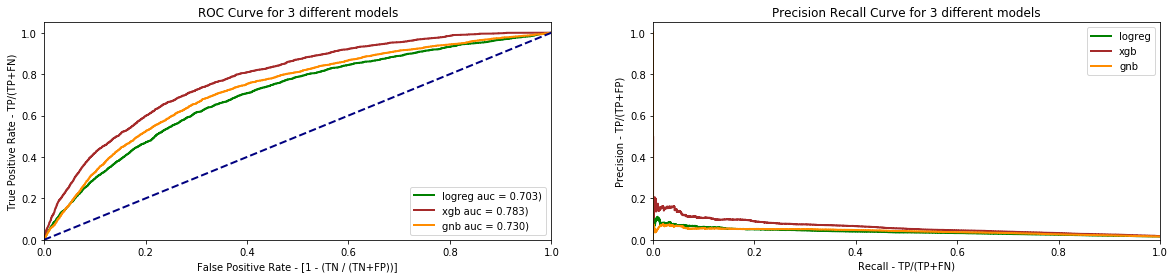

In [116]:
roc_fig = plt.figure(figsize = (20, 4))
lw = 2

ax1 = roc_fig.add_subplot(121)
plt.plot(fpr_logreg, tpr_logreg, color='green',
         lw=lw, label='logreg auc = %0.3f)' % auc_logreg)
plt.plot(fpr_xgb, tpr_xgb, color='brown',
         lw=lw, label='xgb auc = %0.3f)' % auc_xgb)
plt.plot(fpr_gnb, tpr_gnb, color='darkorange',
         lw=lw, label='gnb auc = %0.3f)' % auc_gnb)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate - [1 - (TN / (TN+FP))]')
plt.ylabel('True Positive Rate - TP/(TP+FN)')
plt.title('ROC Curve for 3 different models')
plt.legend(loc="lower right");

ax2 = roc_fig.add_subplot(122)
plt.plot(recall_logreg, precision_logreg, color='green',
         lw=lw, label='logreg')
plt.plot(recall_xgb, precision_xgb, color='brown',
         lw=lw, label='xgb')
plt.plot(recall_gnb, precision_gnb, color='darkorange',
         lw=lw, label='gnb')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('Precision - TP/(TP+FP)')
plt.xlabel('Recall - TP/(TP+FN)')
plt.title('Precision Recall Curve for 3 different models')
plt.legend(loc="top right");

In [107]:
roc_xgb.loc[ roc_xgb.tpr_minus_fpr == max_diff, ]

,xgb_threshold,tpr_xgb,fpr_xgb,tpr_minus_fpr
2793,0.466534,0.711182,0.285793,0.425389


In [112]:
eval_df['xgb_best_threshold_preds'] = np.where(eval_df.xgb_pred_probs >= 0.466534, 1, 0)

In [114]:
pd.crosstab(eval_df.y, eval_df.xgb_best_threshold_preds)

xgb_best_threshold_preds,0,1
y,,
0,83113,33258
1,545,1342


In [115]:
33258 / (33258 + 1342)

0.9612138728323699

In [153]:
precision_recall_xgb_df.loc[ precision_recall_xgb_df.threshold.between(0.46653, 0.46655)]

,model,threshold,precision,recall
75621,xgb,0.466534,0.038758,0.710652
75622,xgb,0.466538,0.038759,0.710652
75623,xgb,0.466538,0.038761,0.710652


In [148]:
precision_recall_xgb_df.iloc[75621]

model              xgb
threshold     0.466534
precision    0.0387583
recall        0.710652
Name: 75621, dtype: object

#### Provide an estimate of performance using an appropriate sample, and show your work.

- across all thresholds for classification, the gradient boosted tree (xgb) is best at recognizing positive cases correctly while minimizing false positives, seen in its ROC curve lying markedly above that of the other 2 models
- the xgb model is also best in the precision-recall curve graph because it has universally higher precision across all values of recall compared to the other models
- #### therefore, among the models built, xgb is the best model: its performance is as follows
    - True Positive Rate: 71%, False Positive Rate: 29%, Precision: 4%, Recall: 71%, AUC: 77%
- however, the xgb model's low precision is very concerning and is one thing that signals that this model is not close to production ready despite performing better than the other 2
- when examining the best threshold for the xgb model, the true positive rate and false positive rates of 71% and 28% are encouraging but insufficient and certainly need to be improved before being used in production
- after reviewing the confusion matrix in the cell immediately preceding this, it is obvious that the model's precision is universally low because [ 33258 / (33258 + 1342)] = 96% of the model's predicted positive cases are actually negatives, making them False Positives -> therefore, the model is still not able to differentiate between positive and negative cases well among the negative cases, requiring significant improvement before moving forward

Some of the things that I would do given more time to improve the model are
1. diaglogue with business stakeholders and analysts regarding trends in fraud cases that they have noticed to inform creating new derived variables and adding new variables
2. determine what other data is available that could be used to add new explanatory variables in the model
3. explore creating other derived explanatory variables, including interactions
4. try other models with different objective functions and parameterizations including support vector machines, neural network, nearest neighbors, etc. to see if their performance is better than the xgb model
5. examine the champion model's performance at different values of hyperparameters with a grid search. for the gradient boosted model, this would include learning rate, number of boosting rounds, weights for positive samples, sampling method, tree depth, lambda regularization parameter, boosting the model based on auc instead of mean average precision